# **Amazon Products -  Case Study ( with NLP and Data Visualization)**

# **Basic text data pre-processing**

We shall first start by importing the libraries required and the dataset.

In [3]:
import numpy as np
import pandas as pd
# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

# Importing dataset
df=pd.read_csv('dataset.csv') 


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let us now look at our data to understand it and see which columns we will be needing for our analysis. We shall drop the unnecessary columns.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

As you can see, the dataframe has 21 columns whereas we will be needing only the columns 'name' , 'reviews.text' , 'reviews.doRecommend' and 'reviews.numHelpful'. Hence, we shall be dropping all the other columns.


In [5]:
df=df[['name','reviews.text','reviews.doRecommend','reviews.numHelpful']]
print("Shape of data=>",df.shape)
df.head()

Shape of data=> (34660, 4)


,name,reviews.text,reviews.doRecommend,reviews.numHelpful
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",This product so far has not disappointed. My c...,True,0.0
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",great for beginner or experienced person. Boug...,True,0.0
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Inexpensive tablet for him to use and learn on...,True,0.0
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I've had my Fire HD 8 two weeks now and I love...,True,0.0
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I bought this for my grand daughter when she c...,True,0.0


Any real life dataset is bound to have missing entries. This makes analysis difficult. Hence, let us drop the  rows with missing entries. 

In [6]:
df.isnull().sum()

name                   6760
reviews.text              1
reviews.doRecommend     594
reviews.numHelpful      529
dtype: int64

In [7]:
df.dropna(inplace=True)
df.isnull().sum()

name                   0
reviews.text           0
reviews.doRecommend    0
reviews.numHelpful     0
dtype: int64

To have a proper analysis of the data, we need to ensure that we have products with at least 400 reviews. We shall filter out such entries using functions such as filter() and lambda function.

A lambda funtion is an anonymous function with its syntax as 
lambda arguments: expression
Lambda functions can have any number of arguments but only one expression. The expression is evaluated and returned

We pass this lambda funtion as an input to a filter function. This function extracts those entries from the data set which satisfy our requirement.



In [8]:
df=df.groupby('name').filter(lambda x:len(x)>400).reset_index(drop=True)
print('Number of products=>',len(df['name'].unique()))

Number of products=> 8


From the dataset we can see that 'reviews.doRecommend' has entries such as True or False. Let's convert this to binary values 1 or 0. The column 'reviews.numHelpful' has floating point values, we shall be converting this also to integer values.

In [9]:
df['reviews.doRecommend']=df['reviews.doRecommend'].astype(int)
df['reviews.numHelpful']=df['reviews.numHelpful'].astype(int)

# **Cleaning Text Data in Python**

Let's take a look at the 'name' column and remove the unnecessary punctuations.

In [10]:
df['name'].unique()

array(['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta',
       'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta',
       'Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,,,',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case',
       'Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,',
       'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers,',
       'Echo (White),,,\r\nEcho (White),,,',
       'Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,'], dtype=object)

In [11]:
df['name']=df['name'].apply(lambda x: x.split(',,,')[0])

Let's next look athe 'reviews.text' column. We can see that this has many contractions and these need to be expanded before further analysis.

In [12]:
for index,text in enumerate(df['reviews.text'][35:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 I love everything about this tablet! The imaging is sharp and clear. It's fast and light weight. Love it!
Review 2:
 Overall a nice product for traveling purposes Value for money
Review 3:
 My children love this table great quality of pictures, excellent camera
Review 4:
 I bought 3 tablets and my family was not disappointed.
Review 5:
 Great tablet fast screen good size never gives me problem


The following cell has a dictionary with the commonly used English contractions. We shall use this dictionary to expand the contractions in our corpus.

In [13]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['reviews.text']=df['reviews.text'].apply(lambda x:expand_contractions(x))

The following cell converts all the text to lowercase as NLP models treat upper-case and lower-case models differenlty.

In [14]:
df['cleaned']=df['reviews.text'].apply(lambda x: x.lower())

Our corpus also has number and words with digits in them. They do not add much value to the data and hence we shall remove them.

In [15]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

The following cell removes all the punctuations in our corpus.

In [16]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

We shall now remove the extra spaces in our corpus.

In [17]:
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

The following cell will enable us to view our corpus after cleaning.

In [18]:
for index,text in enumerate(df['cleaned'][35:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 i love everything about this tablet the imaging is sharp and clear it is fast and light weight love it
Review 2:
 overall a nice product for traveling purposes value for money
Review 3:
 my children love this table great quality of pictures excellent camera
Review 4:
 i bought tablets and my family was not disappointed
Review 5:
 great tablet fast screen good size never gives me problem


We’ll use SpaCy for the removal of stopwords and lemmatization. It is a library for advanced Natural Language Processing in Python and Cython.

Stopwords are the most common words of a language like ‘I’, ‘this’, ‘is’, ‘in’ which do not add much value to the meaning of a document. These values are removed to decrease the dataset size and increase focus on meaningful words.

Lemmatization is a systematic process of reducing a token to its lemma. It uses vocabulary, word structure, part of speech tags, and grammar relations to convert a word to its base form

In [19]:
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


In [20]:
df_grouped=df[['name','lemmatized']].groupby(by='name').agg(lambda x:' '.join(x))
df_grouped.head()

,lemmatized
name,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",product far disappoint child love use like abi...
Amazon Fire Tv,echo learn everyday use daily use place speake...
Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,nice little set slow wish investigate little j...
Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,good value money hand work perfectly purchase ...
Echo (White),compete ipad high end android tablet easily ou...


We shall now create a Document Matrix. A Document Term Matrix provides the frequency of a word in a corpus (collection of documents), which in this case are reviews. It helps in analyzing the occurrence of words in different documents in a corpus.

In [21]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer 
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head(3)

,aa,aaa,aamazon,abandon,abattery,abc,abcmouse,abcmousecom,abcs,abd,ability,abilty,abit,abke,able,abnormal,abode,abook,abound,abount,abouti,aboutif,abroad,abruptly,absence,absofbe,absoluitely,absolute,absolutely,absolutly,absorb,abt,abundance,abundant,abuse,ac,academic,acc,acce,accedently,...,youe,yougo,youit,youkathleen,younameit,young,younger,youngest,youngin,youngster,yourbedmate,youreyesprobably,yous,youse,youshe,youso,youth,youtube,youtubeand,youtubegmail,youtubekid,youtubenetflix,youtubepandora,youversion,youwhat,yr,yrold,yrs,yup,zeepad,zeppelin,zero,zigbee,zinio,zip,zippy,zone,zoo,zoom,zwave
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",0,0,0,0,0,0,0,0,0,0,24,0,1,0,77,0,0,0,0,1,0,0,0,0,0,0,0,3,33,0,0,0,0,0,2,0,0,1,1,0,...,0,0,0,0,0,20,0,0,0,0,0,1,0,0,0,0,1,37,0,0,0,0,0,0,0,23,0,3,0,0,0,4,0,1,0,0,0,0,0,0
Amazon Fire Tv,0,1,1,0,0,0,0,0,0,0,37,0,0,0,121,0,0,0,0,0,0,0,0,1,1,0,0,1,49,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,2,0,1,0,0,1,0,0,0,1,0,0,0,0,0
Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,0,0,0,1,0,2,0,0,0,0,56,0,0,0,131,1,0,1,1,0,0,0,0,0,0,0,0,1,69,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,15,0,0,0,2,1,0,0,0,0,0,0,4,0,0,0,0,0,0,0,10,0,5,0,0,0,4,0,0,0,0,2,0,2,0


# **Exploratory Data Analysis**

For visual representation of our corpus, we shall use Word Clouds. Word clouds are the visual representations of the frequency of different words present in a document. It gives importance to the more frequent words which are bigger in size compared to other less frequent words.

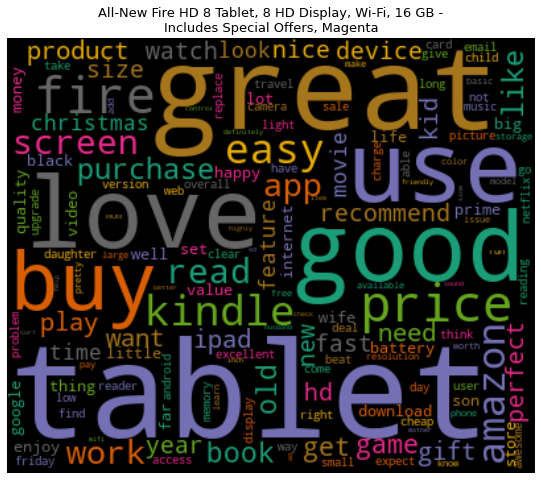

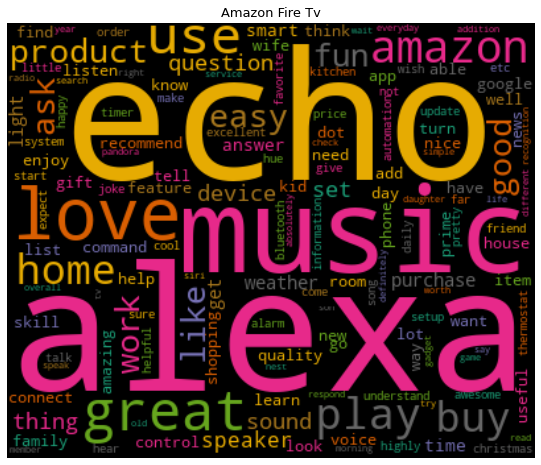

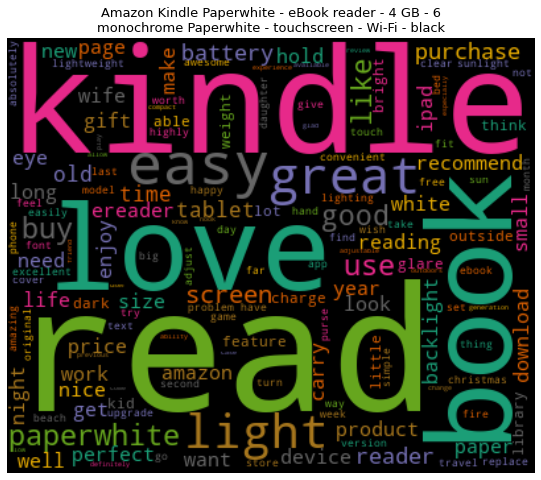

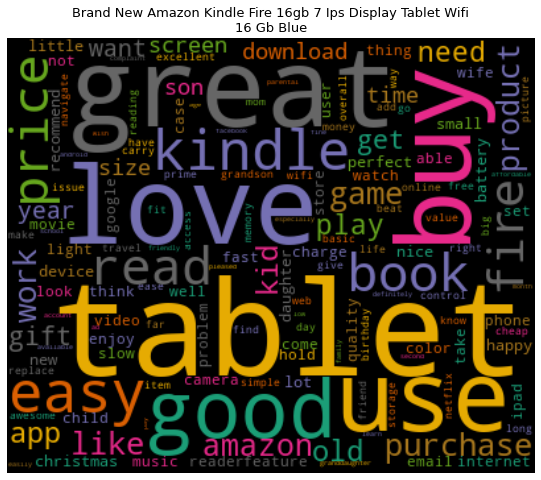

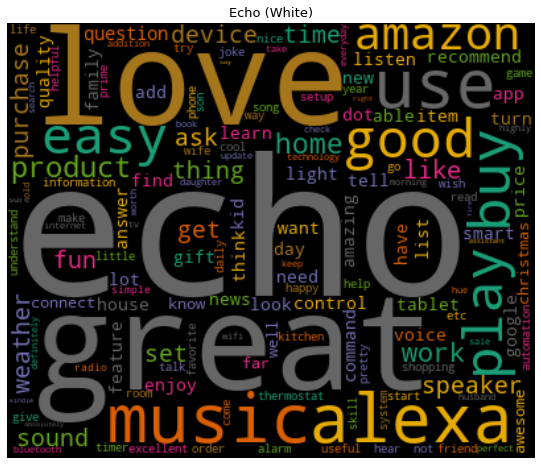

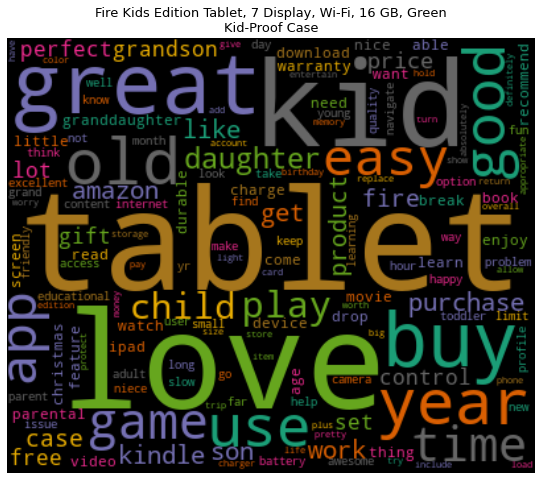

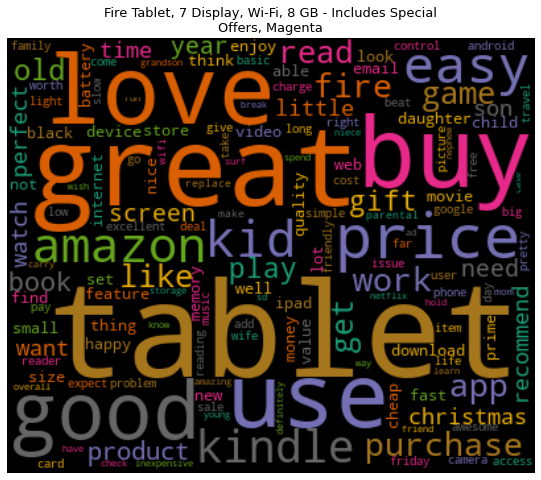

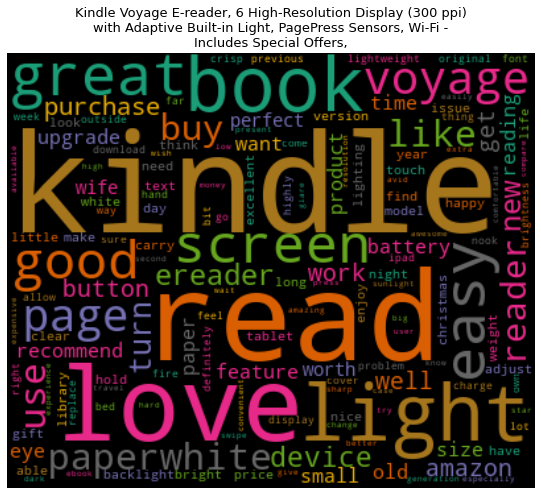

In [22]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)